In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL

import tensorflow as tf

# import tensorflow.compat.v1 as tf 
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


# tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True)) 


In [2]:
import pathlib

from matplotlib.path import Path

data_dir = pathlib.Path('cell_images/')

In [3]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

27538


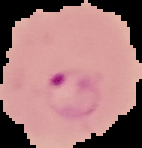

In [4]:
malaria = list(data_dir.glob('parasitized/*'))
PIL.Image.open(str(malaria[0]))


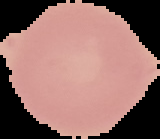

In [5]:
healthy = list(data_dir.glob('uninfected/*'))
PIL.Image.open(str(healthy[0]))


In [6]:
batch_size = 32
img_height = 120
img_width = 120

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 27538 files belonging to 2 classes.
Using 22031 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 27538 files belonging to 2 classes.
Using 5507 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)


['Parasitized', 'Uninfected']


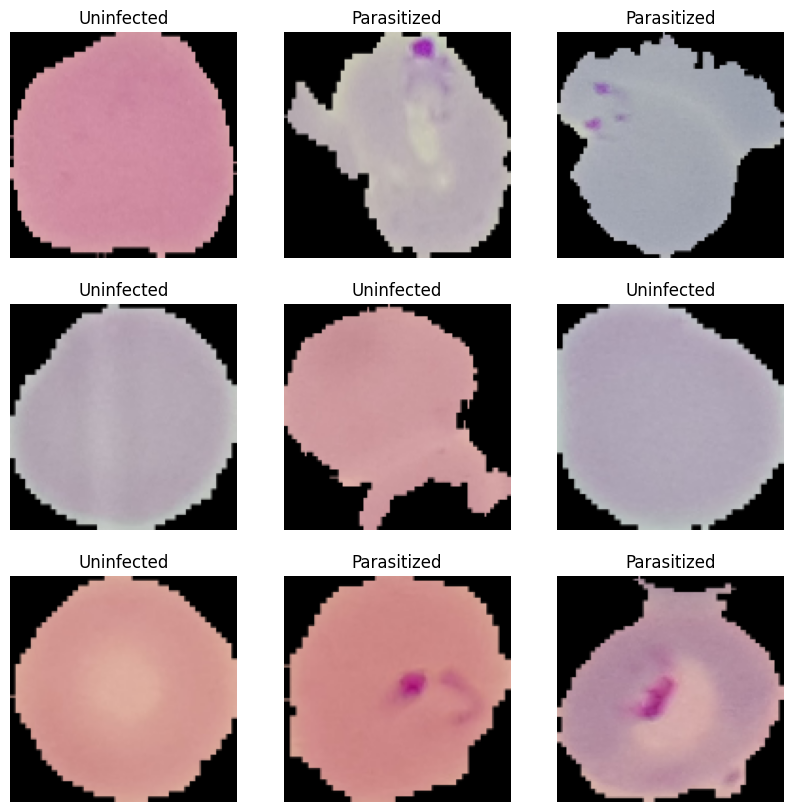

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 120, 120, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = 


In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8411457


In [15]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        1

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

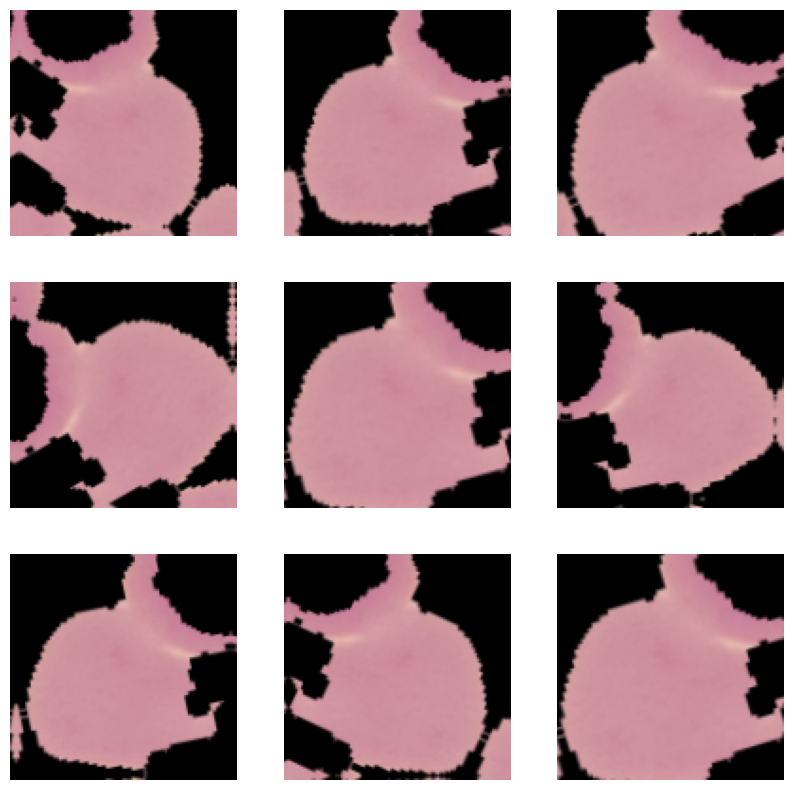

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [22]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 120, 120, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 120, 120, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 60, 60, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                  

In [25]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
689/689 [==============================] - 93s 131ms/step - loss: 0.3590 - accuracy: 0.8382 - val_loss: 0.1795 - val_accuracy: 0.9359
Epoch 2/15
689/689 [==============================] - 88s 128ms/step - loss: 0.1753 - accuracy: 0.9417 - val_loss: 0.1785 - val_accuracy: 0.9481
Epoch 3/15
689/689 [==============================] - 86s 125ms/step - loss: 0.1604 - accuracy: 0.9488 - val_loss: 0.1649 - val_accuracy: 0.9502
Epoch 4/15
689/689 [==============================] - 85s 124ms/step - loss: 0.1512 - accuracy: 0.9535 - val_loss: 0.1450 - val_accuracy: 0.9555
Epoch 5/15
689/689 [==============================] - 85s 123ms/step - loss: 0.1363 - accuracy: 0.9559 - val_loss: 0.1333 - val_accuracy: 0.9568
Epoch 6/15
689/689 [==============================] - 85s 124ms/step - loss: 0.1316 - accuracy: 0.9567 - val_loss: 0.1192 - val_accuracy: 0.9579
Epoch 7/15
689/689 [==============================] - 88s 128ms/step - loss: 0.1296 - accuracy: 0.9581 - val_loss: 0.1341 - val_ac

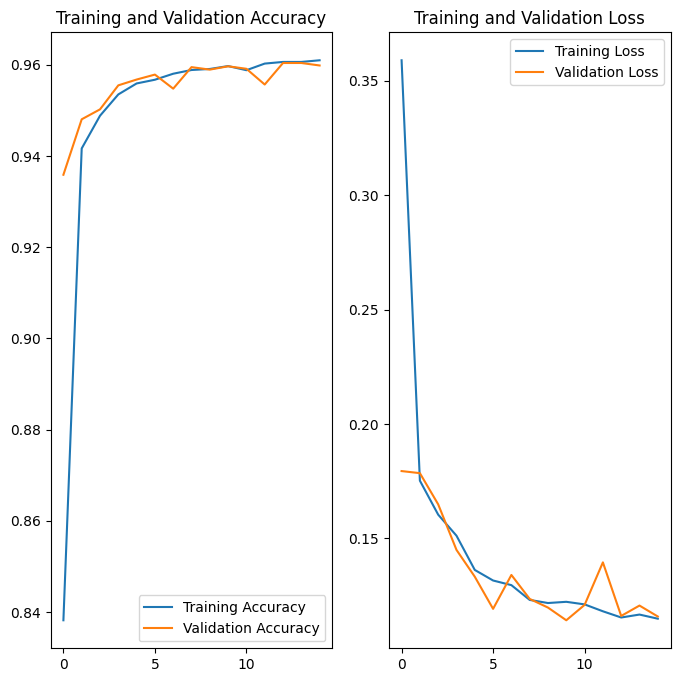

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [35]:
model.save('saved_model/malaria_96.h5')

In [47]:
img_name = "C241NThinF_IMG_20151207_124643_cell_158.png"

path = 'test/'+img_name

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 18ms/step
This image most likely belongs to Uninfected with a 98.44 percent confidence.


In [36]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\gohlk\AppData\Local\Temp\tmpjnisoatf\assets


INFO:tensorflow:Assets written to: C:\Users\gohlk\AppData\Local\Temp\tmpjnisoatf\assets


In [37]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [38]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In [39]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [57]:
img_name = "C119P80ThinF_IMG_20151002_122720_cell_160.png"

path = 'test/'+img_name

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

# assert np.allclose(predictions, predictions_lite)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)


This image most likely belongs to Parasitized with a 98.82 percent confidence.
